In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import warnings
import model_report as mr
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from sklearn import metrics
def get_metrics(true_labels, predicted_labels):
    my_accuracy = np.round(metrics.accuracy_score(true_labels,predicted_labels),4)
    my_precision = np.round(metrics.precision_score(true_labels,predicted_labels,average='weighted'),4)
    my_TPR = np.round(metrics.recall_score(true_labels,predicted_labels,average='weighted'),4)
    my_F1 = np.round(metrics.f1_score(true_labels,predicted_labels,average='weighted'),4)
    
    return my_accuracy, my_precision, my_TPR, my_F1


In [3]:
file_info = "C:\\Users\\blgai\\OneDrive\\Documents\\School\\SMU\\Courses\\Fall 2021\\Capstone A\Data\\cleaned_data_baseline_v1.csv"
df = pd.read_csv(file_info, sep='\t')

In [4]:
df.groupby(df.category).size()

category
bu    11731
dr     1595
ed     3894
mk     8775
os     6789
sp     2535
sx     6557
dtype: int64

In [5]:
from sklearn.model_selection import train_test_split
#get 10% holdout set
train_corpus, holdout_corpus, train_label, holdout_label = train_test_split(df['clean_combined'], 
                                                                           df['category'],
                                                                           test_size=.10,random_state=1234)

#get 80% train and 20% test sets
train_corpus, test_corpus, train_label, test_label = train_test_split(train_corpus,
                                                                      train_label,
                                                                      test_size=.2225,random_state=1234) #.9 * .2225 = .20

train_corpus.shape, test_corpus.shape, holdout_corpus.shape

((29302,), (8386,), (4188,))

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

svm = LinearSVC(penalty='l2',C=1,class_weight={'dr':8,'sx':10},random_state=1234)

feat_select_k = [500,800,1100,1400,1700,2000,2300,2600,2900,3200,3500,3800,4100,4400,4700,5000,5300,5600,5900,6200,6500,6800,7100,7400,7700,8000,8300,8600,8900,9200,9500,9800,10100]

#build BOW features on train corpus
tv = TfidfVectorizer(use_idf=True, min_df=25,max_df=.9, norm="l2",smooth_idf=True)
tv_train_features = tv.fit_transform(train_corpus)
#transform test corpus into features
tv_test_features = tv.transform(test_corpus)
#transform holdout corpus into features
tv_holdout_features = tv.transform(holdout_corpus)


#create an object to collect metrics for comparison
data_dict = []

#select optimal features, train, test, record metrics
for i in feat_select_k:
    
    #find optimal features of size k
    X_opt=SelectKBest(chi2, k=i)
    tv_train_features_trimmed = X_opt.fit_transform(tv_train_features, train_label)
    #create a data frame that includes all features and whether or not they are deemed important by feature_selection
    feat_imp = pd.DataFrame(list(zip(tv.get_feature_names(),X_opt.get_support().tolist())),columns = ['Features','Important'])
    #Now we can grab the important features so that we can select only the important features from the sparse matrix created by TfidfVectorizer
    imp_Feats_array = np.array(feat_imp[feat_imp.Important == True].index)
    #Now we can pull only the important features out of the original train, test, and holdout matrices
    tv_train_features_sub = tv_train_features[:,imp_Feats_array]
    tv_test_features_sub = tv_test_features[:,imp_Feats_array]
    tv_holdout_features_sub = tv_holdout_features[:,imp_Feats_array]
    
    #train model using only the optimal features
    svm.fit(tv_train_features_sub,train_label)
    #get efficacy metrics of trained model
    svm_tfidf_cv_scores = cross_val_score(svm,tv_train_features_sub,train_label,cv=5)
    svm_tfidf_cv_mean_score = np.mean(svm_tfidf_cv_scores)
    svm_tfidf_test_score = svm.score(tv_test_features_sub,test_label)
    svm_predictions = svm.predict(tv_test_features_sub)
    
    accuracy, precision, tpr, f1 = get_metrics(true_labels=test_label,predicted_labels=svm_predictions)
    
    #store metrics in dictionary
    tmp_dict = {'No_Features':i,
                'Model':'SVM',
                'Class_Weights':'dr:8 and sx:10',
                'tfidf_mindf':25,
                'tfidf_maxdf':.9,
                'cv_5_mean_acc':svm_tfidf_cv_mean_score,
                'test_acc':accuracy,
                'precision':precision,
                'TPR/Recall':tpr,
                'F1 Score':f1
               }
    #append metrics from latest model to dictionary object
    data_dict.append(tmp_dict)

#create dataframe from dictionary object
df_overall = pd.DataFrame(data_dict)

#view all metrics
df_overall  

,No_Features,Model,Class_Weights,tfidf_mindf,tfidf_maxdf,cv_5_mean_acc,test_acc,precision,TPR/Recall,F1 Score
0,500,SVM,dr:8 and sx:10,25,0.9,0.813631,0.8207,0.8241,0.8207,0.8214
1,800,SVM,dr:8 and sx:10,25,0.9,0.834380,0.8449,0.8467,0.8449,0.8453
2,1100,SVM,dr:8 and sx:10,25,0.9,0.839806,0.8484,0.8498,0.8484,0.8486
3,1400,SVM,dr:8 and sx:10,25,0.9,0.844618,0.8528,0.8538,0.8528,0.8529
4,1700,SVM,dr:8 and sx:10,25,0.9,0.846905,0.8551,0.8563,0.8551,0.8553
5,2000,SVM,dr:8 and sx:10,25,0.9,0.849226,0.8551,0.8561,0.8551,0.8553
6,2300,SVM,dr:8 and sx:10,25,0.9,0.849567,0.8539,0.8546,0.8539,0.8541
7,2600,SVM,dr:8 and sx:10,25,0.9,0.851717,0.8557,0.8564,0.8557,0.8558
8,2900,SVM,dr:8 and sx:10,25,0.9,0.852160,0.8551,0.8558,0.8551,0.8552
9,3200,SVM,dr:8 and sx:10,25,0.9,0.851205,0.8556,0.8559,0.8556,0.8555


In [7]:
import altair as alt

y_max = df_overall['test_acc'].max()
y_min = df_overall['test_acc'].min()

alt.Chart(df_overall).mark_line().encode(
    alt.Y('test_acc',scale=alt.Scale(domain=(y_min,y_max))),
    x='No_Features'
    
).properties(title="Change in SVM Test Accuracy based on Number of Features - Baseline")

alt.Chart(...)

In [9]:
#grab the best k from analysis above
df_overall[df_overall.test_acc == y_max]

,No_Features,Model,Class_Weights,tfidf_mindf,tfidf_maxdf,cv_5_mean_acc,test_acc,precision,TPR/Recall,F1 Score
11,3800,SVM,dr:8 and sx:10,25,0.9,0.851068,0.8569,0.8572,0.8569,0.8569


In [10]:
#Let's find the top important features and analyze them

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X_opt=SelectKBest(chi2, k=3800)
tv_train_features_trimmed = X_opt.fit_transform(tv_train_features, train_label)
tv_train_features_trimmed.shape

(29302, 3800)

In [11]:
#create a data frame that includes all features and whether or not they are deemed important by feature_selection
feat_imp = pd.DataFrame(list(zip(tv.get_feature_names(),X_opt.get_support().tolist())),columns = ['Features','Important'])
feat_imp[feat_imp.Important == True]

,Features,Important
24,abigail,True
40,abroad,True
48,abstract,True
57,academ,True
58,academi,True
...,...,...
19153,zambeza,True
19155,zamnesia,True
19169,zerotoler,True
19184,zoe,True


In [12]:
#Now we can grab the important features so that we can select only the important features from the sparse matrix created by TfidfVectorizer
imp_Feats_array = np.array(feat_imp[feat_imp.Important == True].index)

In [13]:
#Now we can pull only the important features out of the original train, test, and holdout matrices
tv_train_features_sub = tv_train_features[:,imp_Feats_array]
tv_test_features_sub = tv_test_features[:,imp_Feats_array]
tv_holdout_features_sub = tv_holdout_features[:,imp_Feats_array]

#Examine the new shapes of the sub-selected features
print('TFIDF model:> Train features shape:',tv_train_features_sub.shape,'Test features shape:',tv_test_features_sub.shape,'Holdout features shape:',tv_holdout_features_sub.shape)

TFIDF model:> Train features shape: (29302, 3800) Test features shape: (8386, 3800) Holdout features shape: (4188, 3800)


In [14]:
%%time

from sklearn import svm
clf = svm.SVC(kernel='linear', probability=True, C=1.0, class_weight={'dr':8,'sx':10},random_state=1234)
clf.fit(tv_train_features_sub,train_label)

Wall time: 21min 56s


SVC(class_weight={'dr': 8, 'sx': 10}, kernel='linear', probability=True,
    random_state=1234)

In [15]:
svm_tfidf_test_score = clf.score(tv_test_features_sub,test_label)
print('Test Accuracy:',svm_tfidf_test_score)

Test Accuracy: 0.8559503935129978


In [16]:
import model_evaluation_utils as meu
svm_predictions = clf.predict(tv_test_features_sub)
meu.get_metrics(true_labels=test_label,predicted_labels=svm_predictions)

Accuracy: 0.856
Precision: 0.8587
Recall: 0.856
F1 Score: 0.8567


In [17]:
unique_classes = list(set(test_label))
meu.display_classification_report(true_labels=test_label,predicted_labels=svm_predictions,classes=unique_classes)

              precision    recall  f1-score   support

          os       0.84      0.77      0.80      1393
          sx       0.99      0.99      0.99      1345
          bu       0.85      0.86      0.85      2355
          dr       0.96      0.93      0.95       307
          ed       0.93      0.87      0.90       783
          mk       0.73      0.79      0.76      1709
          sp       0.90      0.86      0.88       494

    accuracy                           0.86      8386
   macro avg       0.88      0.87      0.88      8386
weighted avg       0.86      0.86      0.86      8386



Confusion matrix, without normalization
[[1078   22    8   14  189    2   80]
 [   6  680    0    8   34    2   53]
 [  10    0  287    0    6    0    4]
 [  16    4    0  423   45    1    5]
 [ 109   12    2   18 1351    3  214]
 [   2    0    0    1    4 1334    4]
 [  68   17    1    5  234    5 2025]]


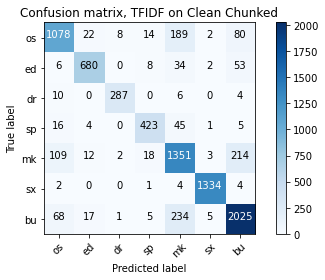

In [18]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(test_label,svm_predictions,labels=['os','ed','dr','sp','mk','sx','bu'])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
mr.plot_confusion_matrix(cnf_matrix, classes=['os','ed','dr','sp','mk','sx','bu'],
                      title='Confusion matrix, TFIDF on Clean Chunked')

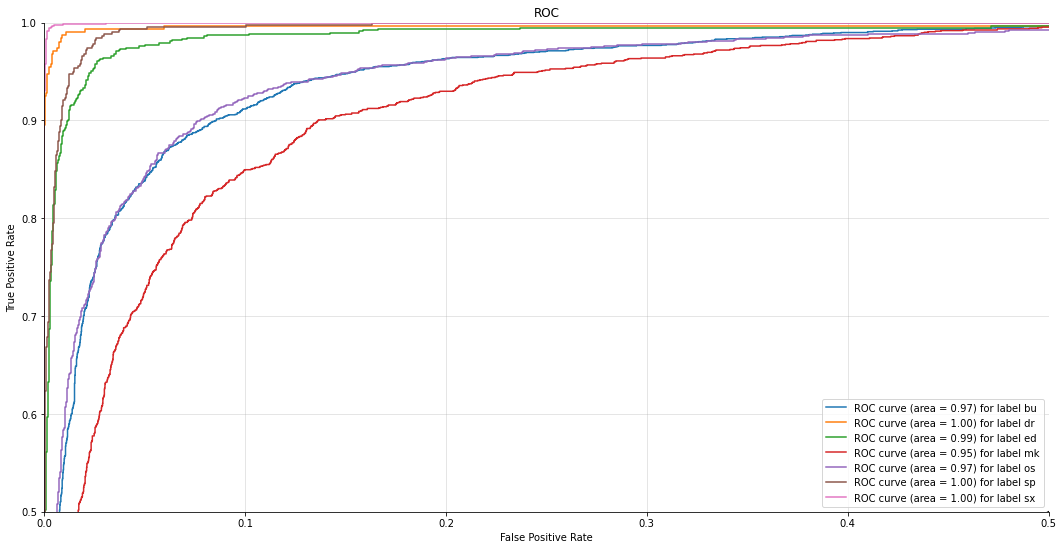

In [19]:
y_proba = clf.predict_proba(tv_test_features_sub)

labels_dict = dict(zip(df.category,df.category))
target_names = sorted(list(labels_dict.values()))

mr.plot_roc_curve(labels=test_label, predictions=y_proba, x_lim=[0.0,0.5], y_lim=[0.5,1.0], target_names=target_names)

In [20]:
df_test_results = pd.DataFrame(list(zip(test_corpus,test_label,svm_predictions, y_proba)),columns = ['terms','category','predicted_label','probability'])
df_test_results['match'] = np.where(df_test_results['category']==df_test_results['predicted_label'],1,0)

In [21]:
rpt = mr.generate_report(df_test_results)
rpt

{'totalSamples': 8386,
 'overallAccuracy': 0.8559503935129978,
 'byCategory': {'sx': {'totalSamples': 1345, 'accuracy': 0.9918215613382899},
  'dr': {'totalSamples': 307, 'accuracy': 0.9348534201954397},
  'ed': {'totalSamples': 783, 'accuracy': 0.8684546615581098},
  'bu': {'totalSamples': 2355, 'accuracy': 0.8598726114649682},
  'sp': {'totalSamples': 494, 'accuracy': 0.8562753036437247},
  'mk': {'totalSamples': 1709, 'accuracy': 0.7905207723815096},
  'os': {'totalSamples': 1393, 'accuracy': 0.7738693467336684}}}

In [22]:
#pickle the model
import pickle

filename = 'svm_baseline_v1.sav'
pickle.dump(clf,open(filename,'wb'))

In [23]:
#pickle the data

#training data
filename = 'tv_train_features_sub_baseline_v1.pkl'
pickle.dump(tv_train_features_sub,open(filename,'wb'))

#test data
filename = 'tv_test_features_sub_baseline_v1.pkl'
pickle.dump(tv_test_features_sub,open(filename,'wb'))

#holdout data
filename = 'tv_holdout_features_sub_baseline_v1.pkl'
pickle.dump(tv_holdout_features_sub,open(filename,'wb'))

#save labels
pickle.dump(train_label, open('train_label_baseline.pkl','wb'))
pickle.dump(test_label, open('test_label_baseline.pkl','wb'))
pickle.dump(holdout_label, open('holdout_label_baseline.pkl','wb'))
#save TFIDFVectorizer to disk
# pickle.dump(tv,open('TFIDFVectorizer.pkl','wb'))